---

### Before continuing, we must download the dataset we intend to work with

The recipe dataset we will explore here was published as part of a machine learning competition held in 2015.
While the data is [freely available](https://www.kaggle.com/datasets/kaggle/recipe-ingredients-dataset?resource=download) from the Kaggle website, there is no explicit permission to redistribute it.

Let's first check whether you have the data already.

In [24]:
from pathlib import Path
from IPython.display import Markdown
path_recipes = Path("data/recipes.zip")
if path_recipes.is_file():
    display(Markdown("**All good, you have the recipe dataset! Proceed to the [Context section](#context).**"))
else:
    display(Markdown("Please follow the instructions below to gather the dataset."))

Please follow the instructions below to gather the dataset.

To get your copy of the recipes dataset:

1. With your Internet browser, open a new tab or window to [browse over here.](https://www.kaggle.com/datasets/kaggle/recipe-ingredients-dataset)
2. In the upper-right corner of this window, click on 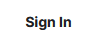 to authenticate to Kaggle.
3. You get the following dialog:<br>
    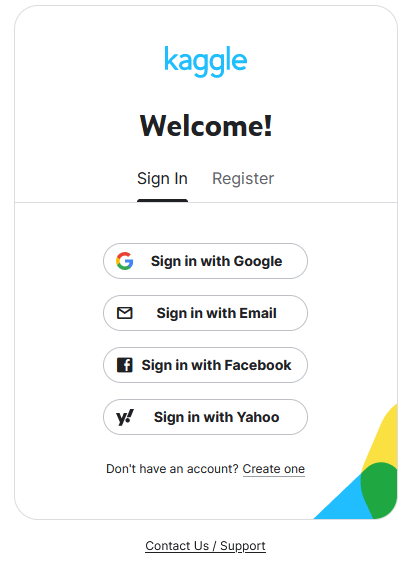<br>
    Click on either option to sign into your Kaggle account. If you don't have a Kaggle account, use the **Register** tab to create one. It's quick and it's free. Use a personal or one-off e-mail address, and on may we carry.
4. Once you are authenticated and signed into Kaggle, you are returned to the page you browsed to. Click on 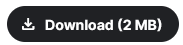 close to the top of the page.
5. Your browser then just downloaded a file under the name `archive.zip`. Look it up so as to know in which folder of your own computer this file has been downloaded.
6. Close the tab or window you opened to browse to the Kaggle website. You are back to your Jupyter Lab or Notebook.
7. Upload the `archive.zip` file to the Jupyter system. In Jupyter Lab, the upload button looks like 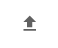, on the left-hand sidebar, just below the main menu. Click this button!
8. In the file selection dialog, retrieve and select the `archive.zip` file. One moment later, it is uploaded!
9. Run the following cell to have the dataset be tucked in the preferred place.

In [31]:
from hashlib import md5
for path_zip in Path(".").glob("*.zip"):
    contents = path_zip.read_bytes()
    if md5(contents).hexdigest() == "586bfe54c9565d7626208026e8a6ec21":
        path_recipes.parent.mkdir(parents=True, exist_ok=True)
        path_recipes.write_bytes(contents)
        path_zip.unlink()
        break
if path_recipes.is_file():
    display(Markdown("Found the recipe dataset Zip file and tucked it away. We are good to go!"))
else:
    display(Markdown("Unfortunately, it seems the recipe dataset Zip file was not uploaded in the notebook directory, where it is expected. Try again, get assistance if you are stuck."))

Found the recipe dataset Zip file and tucked it away. We are good to go!

---



# <div style="height: 1in"></div><center><span style="color: #7088b8; font-weight: normal; font-size: xxx-large;">Vectorizing recipes as <em>bags of ingredients</em></span></center>

This tutorial introduces the basics of turning data into vectors to gain insight into its innate patterns.

# Context: I'm growing hungry

We pursue here the [purpose](README.md#purpose) of surveying a dataset:
we want to observe which data elements are similar to which others, and how.

In [27]:
import bokeh.io
import glasbey as gb
import json
import numpy as np
import pandas as pd
import panel as pn
import thisnotthat as tnt
import umap
import vectorizers as vz
import vectorizers.transformers as vzt
from zipfile import ZipFile

The following cell sets up a notebook extension to enable data visualization tools.

In [2]:
bokeh.io.output_notebook()
pn.extension()

Loading BokehJS ...

The data we will look at here consists in culinary recipes,
for each of which we have the list of ingredients.

In [38]:
with ZipFile(path_recipes) as file_data:
    # train = json.loads(file_data.read("train.json"))
    # test = json.loads(file_data.read("test.json"))
    # data = pd.DataFrame(train + test).set_index("id").sort_index()
    data = pd.DataFrame(json.loads(file_data.read("train.json"))).set_index("id").sort_index()
data

,cuisine,ingredients
id,,
0,spanish,"[mussels, ground black pepper, garlic cloves, ..."
1,mexican,"[tomatoes, diced red onions, paprika, salt, co..."
2,french,"[chicken broth, truffles, pimentos, green pepp..."
3,chinese,"[fresh ginger, sesame oil, frozen peas, cooked..."
4,italian,"[orange peel, cookies, vanilla ice cream, gran..."
...,...,...
49712,indian,"[garam masala, salt, ground cumin, finely chop..."
49713,southern_us,"[black pepper, large eggs, creole seasoning, r..."
49714,irish,"[chopped fresh thyme, chopped fresh sage, onio..."


Let's draw attention to the structure of the dataset above.
Each row of the `data` table corresponds to one recipe.
Let's look at the very first recipe.

In [39]:
data.iloc[0]

cuisine                                                  spanish
ingredients    [mussels, ground black pepper, garlic cloves, ...
Name: 0, dtype: object

The recipe is expressed by two *attributes*.
The first is called **cuisine**, and it is a single word.
Look up how many types of cuisine we have.

In [40]:
len(set(data["cuisine"]))

20

Only 20 types.
We can understand these as recipe _categories_.

The second attribute is called **ingredients**.
It is &mdash; surprise! &mdash; the list of ingredients processed into the recipe.

In [41]:
data.loc[0]["ingredients"]

['mussels',
 'ground black pepper',
 'garlic cloves',
 'saffron threads',
 'olive oil',
 'stewed tomatoes',
 'arborio rice',
 'minced onion',
 'medium shrimp',
 'fat free less sodium chicken broth',
 'green peas']

How many lists of ingredients are there?
(Be patient, answering this question takes a while.)

In [44]:
%%time
len(data["ingredients"].apply(sorted).drop_duplicates())

CPU times: user 12.9 s, sys: 423 ms, total: 13.4 s
Wall time: 13.3 s


39243

The answer is: nearly as many lists of ingredients as we have recipes.
<a id="recipe-list-ingredients"></a>Therefore, we can say that each recipe is **characterized** by its list of ingredients.
Any gourmet looking at this will say:

>*Wait a second, decorporated math person: a recipe is characterized by its ingredients, yes, but also by the steps for processing them.*

Of course, my dear gourmet, but here's a math person trick: *let's assume we don't care*!
A statement like *a recipe is a list of ingredients* is an assumption we can use to build a **model** for recipes.
As statistician George Box is [oft quoted](https://en.wikipedia.org/wiki/All_models_are_wrong):

> All models are wrong, some are useful.

Perhaps this wrong assertion on recipes can still give us some insight into the whole set of recipes we have.
So we carry on with the following two observations:

1. In our data, the **cuisine** expresses a category of the recipe.
2. In our data, the **ingredients** list characterizes each recipe.

## *Steak, blé d'Inde, patates*

Afford this author a little digression.
One of the best sitcom to be produced in Québec was titled [*La Petite Vie*](https://fr.wikipedia.org/wiki/La_Petite_Vie).
It ran across four seasons, from 1993 to 1998.
Ask most Quebecers who watched any television in the 90s, there is likely a gag from this show they remember fondly.

My own favorite from this show has to be the *pâté chinois* running gag.
Pâté chinois is the simpler, peasantly Quebecer version of shepherd's pie.
It is made as a baked dish in three layers: minced hamburger at the bottom, cream corn in the middle, and mashed potatoes on top.
In short: *mince, corn, taters*.
In La Petite Vie, the character of Thérèse is the ditzy daughter of Popa and Moman.
She tries again and again to make pâté chinois, but manages to ruin it with ever sillier mistakes:
laying ingredients side by side instead of as superposed layers,
replacing corn with popcorn,
putting sprinkles on top,
and so on.
And each time her mom chides her softly:

> Moman: *C'est pas compliqué, Thérèse: steak, blé d'Inde, patates.*
>
> Thérèse: *Steak, blé d'Inde, patates! Steak, blé d'Inde, patates!*

Translated: "This isn't hard, Thérèse: mince, corn, taters!"

Please indulge a short watch:

In [45]:
%%html
<iframe src="https://www.facebook.com/plugins/video.php?height=314&href=https%3A%2F%2Fwww.facebook.com%2FArchivesRadioCanada%2Fvideos%2F223729693365497%2F&show_text=false&width=560&t=0" width="560" height="314" style="border:none;overflow:hidden" scrolling="no" frameborder="0" allowfullscreen="true" allow="autoplay; clipboard-write; encrypted-media; picture-in-picture; web-share" allowFullScreen="true"></iframe>

The point of this is that members of the Tutte Institute get to field many data science questions.
Many take the form

> I have data, lots of data! and I want to find the X in it. What model should I make? Should I use fashionable library Y? Should I do AI?

Our answer would be: start with **steak, blé d'Inde, patates** &mdash; but not with food, of course.
If you can describe your data as:

> Each data object is a bag of elements,

then the first thing that should be tried, every time, without exception, is this simple, easy, 3-step sequential recipe.

1. Vectorize
2. Information weight transform
3. UMAP

This embeds the data objects in a two-dimensional vector space.
In other words, **it transforms every object into a point on a plane.**
This embedding projects the local similarity structure of the dataset onto the Euclidean distance between the 2D vectors.
In other words, **similar data objects become points that are close to each other on the plane.**

Let's repeat this, it is very important.
The model assumption above is very light and simple.
If the dataset is made of objects that are sequences, lists, arrays, sets, logs, collections of smaller elements, such as words, tokens, integers, booleans, dates, paths, hashes, symbols, hieroglyphs;
then one can say *each data object is a bag of elements*.

Then, automatically, one should think: C'est pas compliqué, Thérèse, **vectors, infoweight, UMAP**.

This recipe provides a model that, when used for analyzing a corpus of short text documents, is called a *bag of words*.
While it is simple and easy to process (given the appropriate tools -- UMAP is not a trivial computation),
it can be surprisingly effective at revealing correlation phenomena among the dataset &mdash;
groups of similar data objects.
The simplicity of bags of words models make them paramount as first thing to compute,
so that we can compare it to the results of any smarter approach.
The bag of words is the minimum baseline that smart should beat.

So, back to our recipes dataset.
We said [earlier](#recipe-list-ingredients) that *a recipe is a list of ingredients*.
Since every ingredient is a definitively a discrete object,
we could rephrase as

> A recipe is a bag of ingredients.

Ok, then we compute a bag of words model, at least as a first approximation. Vectors, infoweight, UMAP.

# Step 1: from lists of ingredients to vectors

In [5]:
%%time
vz_ngram = vz.NgramVectorizer().fit(data["ingredients"])
vz_ngram

CPU times: user 3.02 s, sys: 84.6 ms, total: 3.1 s
Wall time: 3.12 s


NgramVectorizer()

In [6]:
vz_ngram._train_matrix

<49718x7137 sparse matrix of type '<class 'numpy.float32'>'
	with 535644 stored elements in Compressed Sparse Row format>

In [7]:
len(vz_ngram.column_index_dictionary_)

7137

In [8]:
[vz_ngram.column_index_dictionary_[i] for i in range(10)]

['(    oz.) tomato sauce',
 '(   oz.) tomato paste',
 '(10 oz.) frozen chopped spinach',
 '(10 oz.) frozen chopped spinach, thawed and squeezed dry',
 '(14 oz.) sweetened condensed milk',
 '(14.5 oz.) diced tomatoes',
 '(15 oz.) refried beans',
 '1% low-fat buttermilk',
 '1% low-fat chocolate milk',
 '1% low-fat cottage cheese']

<Axes: >

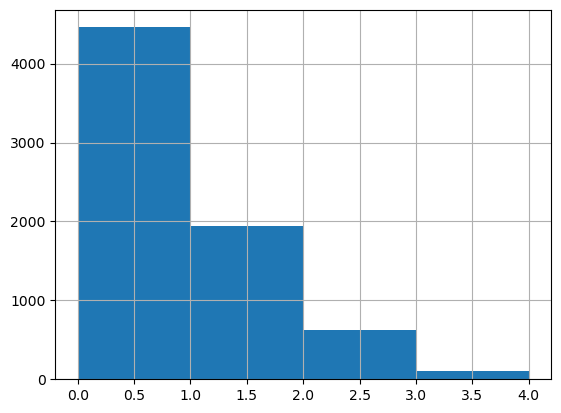

In [9]:
counts_raw = vz_ngram._train_matrix
distribution_tokens = np.asarray(np.sum(counts_raw, axis=0)).squeeze()
pd.Series(np.log10(distribution_tokens)).hist(bins=[0, 1, 2, 3, 4])

In [10]:
counts_iwt = vzt.InformationWeightTransformer().fit_transform(counts_raw)
counts_iwt

<49718x7137 sparse matrix of type '<class 'numpy.float64'>'
	with 535644 stored elements in Compressed Sparse Row format>

<Axes: >

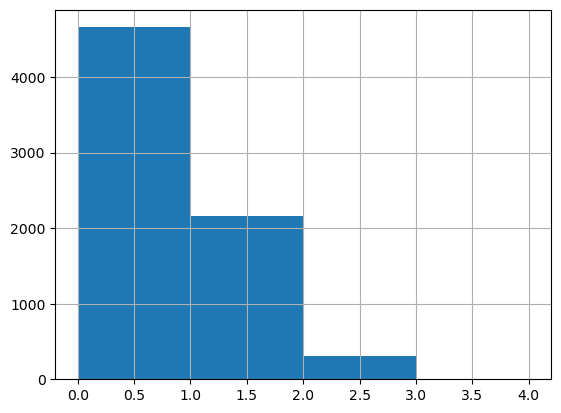

In [11]:
distribution_iwt = np.asarray(np.sum(counts_iwt, axis=0)).squeeze()
pd.Series(np.log10(distribution_iwt)).hist(bins=[0, 1, 2, 3, 4])

In [12]:
%%time
u2 = umap.UMAP(metric="hellinger", unique=True).fit_transform(counts_iwt)
u2

/home/hamelin/tutorials/env/main/lib/python3.11/site-packages/umap/umap_.py:126: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 773 edges.
It has only fully disconnected 46 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


CPU times: user 2min 40s, sys: 12.5 s, total: 2min 53s
Wall time: 36.3 s


array([[ 4.677192  ,  1.261084  ],
       [-0.26037583,  0.9007471 ],
       [ 5.6655464 ,  5.4238443 ],
       ...,
       [-0.48214594,  0.7289502 ],
       [ 1.5514354 ,  6.5503106 ],
       [-0.63316816,  1.2103659 ]], dtype=float32)

In [13]:
cuisines = data["cuisine"].copy().fillna("UNKNOWN")
types_cuisine = sorted(cuisines.unique())
types_cuisine

['UNKNOWN',
 'brazilian',
 'british',
 'cajun_creole',
 'chinese',
 'filipino',
 'french',
 'greek',
 'indian',
 'irish',
 'italian',
 'jamaican',
 'japanese',
 'korean',
 'mexican',
 'moroccan',
 'russian',
 'southern_us',
 'spanish',
 'thai',
 'vietnamese']

In [14]:
palette = gb.extend_palette(["#eeeeee"], len(types_cuisine))
palette

['#eeeeee',
 '#00008e',
 '#aa0000',
 '#008200',
 '#c639ff',
 '#0096c2',
 '#282008',
 '#8ef314',
 '#ff9200',
 '#650061',
 '#927575',
 '#ff3d8e',
 '#00dbb6',
 '#5941ff',
 '#005955',
 '#ffaaff',
 '#9aaa5d',
 '#6d5500',
 '#aabeff',
 '#ffe77d',
 '#55000c']

In [ ]:
plot = tnt.BokehPlotPane(
    u2,
    labels=list(cuisines),
    hover_text=cuisines + " | " + data["ingredients"].map(", ".join),
    label_color_mapping=dict(zip(types_cuisine, palette)),
    width=800,
    height=800,
    show_legend=False,
    marker_size=.025
)
editor = tnt.LabelEditorWidget(labels=plot.labels, color_factors=types_cuisine, color_palette=palette, selectable_legend=True)
editor.link_to_plot(plot)
pn.Row(plot, editor, height=1000)